# PySpark Case Studies

### Guide on How to Work with PySpark on Google Colab
---

In [ ]:
# Connecting Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Setting up PySpark in Colab
# 1. First task is to download Java.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2. Install Apache Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz

!tar -xzvf /content/spark-3.4.0-bin-hadoop3.tgz

# 3. Install and that is the findspark library. It will locate Spark on the system and import it as a regular library.
!pip install -q findspark

# 4. set the environment path. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

# 5. We need to locate Spark in the system. For that, we import findspark and use the findspark.init() method.
import findspark
findspark.init('spark-3.4.0-bin-hadoop3')

# 6. Now, we can import SparkSession from pyspark.sql and create a SparkSession, which is the entry point to Spark.
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

# 7. To view the Spark UI, you would have to include a few more lines of code to create a public URL for the UI page.
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip
#get_ipython().system_raw('./ngrok http 4050 &')
#!curl -s http://localhost:4040/api/tunnels

### EIA
---

In [ ]:
# Eia - Download dataset
!wget www.datascientist.com.br/bigdata/download.zip
!unzip download.zip -d .
!mv download datasets
!rm download.zip spark-3.4.0-bin-hadoop3.tgz

#### RDD - Resilient Distributed Datasets
---

1.   Estrutura de baixo nivel
2.   Dados "imutaveis", distribuidos pelo cluster
3.   Em memoria
4.   Pode ser persistido em disco
5.   Tolerante a falha
6.   Operacoes sobre um RDD cria um novo RDD
7.   Complexo e verboso

#### Dataset e Dataframes
---

Dataset:

1.  Disponivel apenas em Java e Scala
2.  Nao disponiveis em R e Python

Dataframe:
1.  Similar a uma tabela de banco de dados relacional
2.  Imutavel
3.  Com schema conhecido
4.  Linhagem preservada
5.  Colunas podem ter tipos diferentes
6.  Existem analises comuns: agrupar, ordernar, filtrar e etc...
7.  Spark pode otimizar estas analises atraves de planos de execucao

---
**Lazy Evaluation**

Processo de transformacao so ocorre quando existe uma acao

---

Tipos de dados

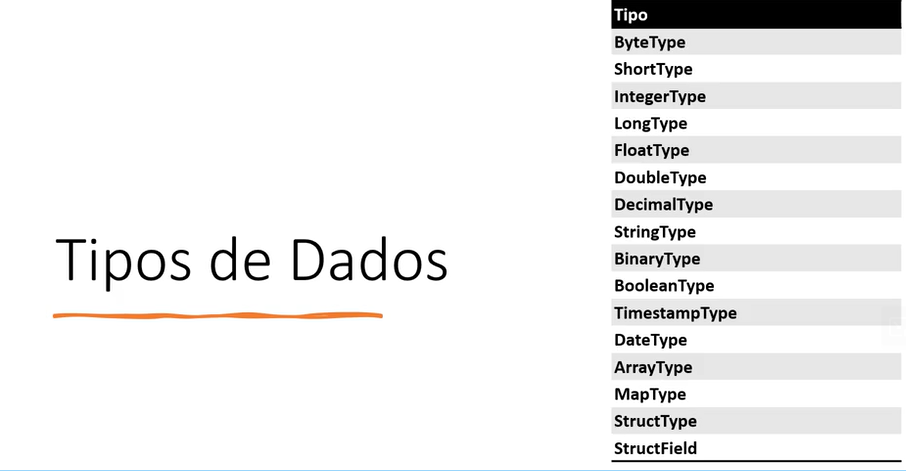

Schema

1.  Spark pode inferir a partir de parte dos dados ou podemos definir o schema
2.  Vantagens de definir:
  * Definicao de tipo de dados correta
  * Sem overhead para inferir o schema 




In [ ]:
# Create dataframe without putting schema
from pyspark.sql import SparkSession

df1 = spark.createDataFrame([('Marcelo', 33),('Jully', 31),('Arthur',0)])
df1.show()

In [ ]:
# Create dataframe with schema
from pyspark.sql import SparkSession

schema = 'Id INT, Nome STRING'
dados = [[1,'Marcelo'],[2,'Arthur']]

df2 = spark.createDataFrame(dados, schema)

df2.show()
#df2.show(1) # n of rows that will be returned and displayed.

In [ ]:
from pyspark.sql.functions import sum

schema2 = "Produtos STRING, Vendas INT"
vendas = [ ['Caneta', 10], ['Lapis', 20], ['Caneta', 40] ]

df3 = spark.createDataFrame(vendas, schema2)

agrupado = df3.groupBy('Produtos').agg(sum('Vendas')).show() # Faz agregacao do produto canetas

#df3.select('Produtos','Vendas').show() # Filtra apenas as colunas de um dataframe

In [ ]:
# usando expressoes sql
from pyspark.sql.functions import expr

df3.select('Produtos','Vendas', expr('Vendas * 0.2')).show() # Calcula 20% de cada venda

In [ ]:
# Ver o schema de um dataframe
df3.schema

# Ver colunas
df3.columns

In [ ]:
from pyspark.sql.types import *
from pyspark.sql import functions as Func

# Lendo arquivos csv (Inferindo schema)
arq_schema = 'id INT, nome STRING, status STRING, cidade STRING, vendas INT, data  STRING'
despachantes = spark.read.csv('/content/datasets/despachantes.csv', header=False, schema =arq_schema).show()

In [ ]:
from pyspark.sql.types import *

# Lendo arquivos csv (Spark Inferindo schema)
desp_autoschema = spark.read.load('/content/datasets/despachantes.csv', header= False, format = 'csv', sep= ',', inferSchema= True).show()

In [ ]:
from pyspark.sql import functions as Func
from pyspark.sql.types import *
from pyspark.sql.functions import *

arq_schema = 'id INT, nome STRING, status STRING, cidade STRING, vendas INT, data  STRING'
despachantes = spark.read.csv('/content/datasets/despachantes.csv', header=False, schema =arq_schema)

# AND --> &
# OR  --> |
# NOT --> ~

# Select com condicionais
print("SELECT")
despachantes.select("id", "nome", "vendas").where(Func.col("vendas") > 20).show()

# Usando AND 
print("Using AND")
despachantes.select("id", "nome", "vendas").where((Func.col("vendas") > 20) & (Func.col("vendas") < 40)).show()

# Renomeia nome coluna
print("Renomeia coluna")
novodf = despachantes.withColumnRenamed("nome","nomes")
novodf.columns

# Muda o tipo de dados, nao eh possivel fazer o dataframe de origem
print("Cria a coluna data2 com tipo de dados timestamp")
despachantes2 = despachantes.withColumn("data2", to_timestamp(Func.col("data"), "yyy-MM-dd"))
despachantes2.schema

print("Retorna o ano do campo data")
despachantes2.select(year("data")).show()

print("Faz o distinct do ano do campo data")
despachantes2.select(year("data")).distinct().show()

print("Retorna o nome, ano ordenados pelo nome")
despachantes2.select("nome", year("data")).orderBy("nome").show()

print("Conta as datas")
despachantes2.select("data").groupBy(year("data")).count().show()

print("Soma a quantidade de vendas")
despachantes2.select(Func.sum("vendas")).show()